In [22]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

## Subtask 1

In [23]:
df = pd.read_csv('bank.csv')

for column in df.columns:
    unique = df[column].unique()
    if df[column].dtype == 'int64':
        continue
    print("Kolumna: ", column)
    print(unique)

df.isnull().sum().sum()

Kolumna:  job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
Kolumna:  marital
['married' 'single' 'divorced']
Kolumna:  education
['secondary' 'tertiary' 'primary' 'unknown']
Kolumna:  default
['no' 'yes']
Kolumna:  housing
['yes' 'no']
Kolumna:  loan
['no' 'yes']
Kolumna:  contact
['unknown' 'cellular' 'telephone']
Kolumna:  month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Kolumna:  poutcome
['unknown' 'other' 'failure' 'success']
Kolumna:  deposit
['yes' 'no']


np.int64(0)

In [24]:
numerical_cols = [
    col for col in df.columns
    if df[col].dtype == 'int64' and col != 'deposit'
]

categorical_cols = [
    col for col in df.columns
    if df[col].dtype != 'int64' and col != 'deposit'
]

X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

y_train = y_train.map({'yes': 1, 'no': 0}).astype(int)
y_test = y_test.map({'yes': 1, 'no': 0}).astype(int)

In [25]:
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [26]:
model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42)),
    ]
)
model_pipeline.fit(X_train, y_train)
print(model_pipeline.predict(X_test))
y_proba = model_pipeline.predict_proba(X_test)[:, 1]
print(model_pipeline.predict_proba(X_test))

[0 1 1 ... 0 1 1]
[[0.67077588 0.32922412]
 [0.01836995 0.98163005]
 [0.41043425 0.58956575]
 ...
 [0.85834555 0.14165445]
 [0.04442006 0.95557994]
 [0.48133124 0.51866876]]


In [27]:
thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
results = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    Accuracy = (TP + TN) / (TP + FP + TN + FN)
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    results.append({
        'Próg': threshold,
        'TP': TP, 'FN': FN, 'FP': FP, 'TN': TN,
        'Czułość (TPR)': round(TPR, 4),
        'FPR': round(FPR, 4),
        '(Accuracy)': round(Accuracy, 4),
        '(Precision)': round(Precision, 4)
    })

results = pd.DataFrame(results)
results


,Próg,TP,FN,FP,TN,Czułość (TPR),FPR,(Accuracy),(Precision)
0,0.10,1058,9,761,405,0.9916,0.6527,0.6552,0.5816
1,0.25,1009,58,379,787,0.9456,0.3250,0.8043,0.7269
2,0.50,833,234,194,972,0.7807,0.1664,0.8083,0.8111
3,0.75,601,466,79,1087,0.5633,0.0678,0.7559,0.8838
4,0.90,376,691,34,1132,0.3524,0.0292,0.6753,0.9171


## Subtask 2

570


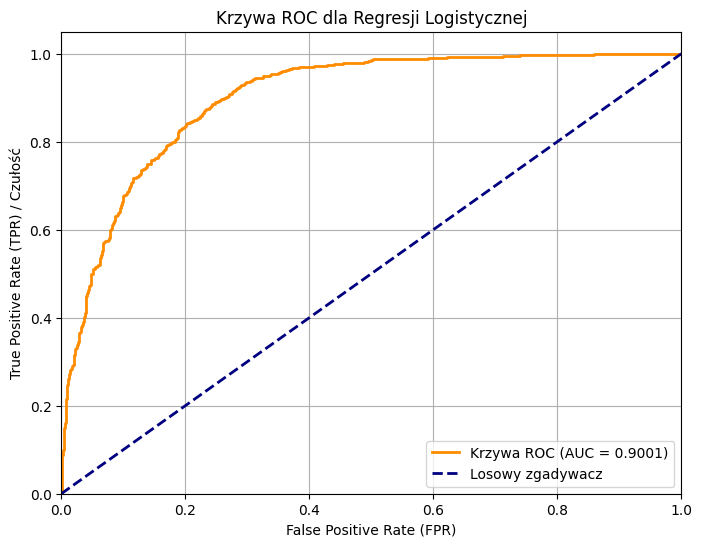

In [35]:
# we can calculate roc with lib

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Losowy zgadywacz')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Czułość')
plt.title('Krzywa ROC dla Regresji Logistycznej')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Subtask 3

In [40]:
cost_FP = 10
cost_FN = 3

total_costs = []

for i, t in enumerate(thresholds):
    y_pred_t = (y_proba >= t).astype(int)

    cm = confusion_matrix(y_test, y_pred_t)
    TN, FP, FN, TP = cm.ravel()

    current_cost = (cost_FP * FP) + (cost_FN * FN)
    total_costs.append({'Threshold': t, 'Cost': current_cost, 'FP': FP, 'FN': FN})


costs_df = pd.DataFrame(total_costs)

optimal_row = costs_df.loc[costs_df['Cost'].idxmin()]

print("\n--- Wybór Optymalnego Progu z Uwagą na Koszty ---")
print(f"Minimalny Całkowity Koszt: **{optimal_row['Cost']:.0f}**")
print(f"Optymalny Próg Klasyfikacji: **{optimal_row['Threshold']:.4f}**")
print(f"Dla tego progu: FP = {optimal_row['FP']:.0f}, FN = {optimal_row['FN']:.0f}")

optimal_threshold = optimal_row['Threshold']


--- Wybór Optymalnego Progu z Uwagą na Koszty ---
Minimalny Całkowity Koszt: **2162**
Optymalny Próg Klasyfikacji: **0.8106**
Dla tego progu: FP = 56, FN = 534


## Subtask 4 (not whole)

In [30]:
feature_names = model_pipeline['preprocessor'].get_feature_names_out()

coefficients = model_pipeline['classifier'].coef_[0]


feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

display(feature_importance_df)

top_2_features = feature_importance_df.sort_values(
    by='Abs_Coefficient', ascending=False
).head(2)

print("--- Dwa Najważniejsze Predykatory ---")
print(top_2_features[['Feature', 'Coefficient']])


feature_1 = top_2_features.iloc[0]['Feature'].split('__')[1]
feature_2 = top_2_features.iloc[1]['Feature'].split('__')[1]

,Feature,Coefficient,Abs_Coefficient
0,numerical__age,-0.032912,0.032912
1,numerical__balance,0.069864,0.069864
2,numerical__day,0.046751,0.046751
3,numerical__duration,1.910389,1.910389
4,numerical__campaign,-0.245362,0.245362
5,numerical__pdays,-0.027858,0.027858
6,numerical__previous,0.035116,0.035116
7,categorical__job_admin.,0.209883,0.209883
8,categorical__job_blue-collar,-0.109234,0.109234
9,categorical__job_entrepreneur,-0.234591,0.234591


--- Dwa Najważniejsze Predykatory ---
                          Feature  Coefficient
3             numerical__duration     1.910389
49  categorical__poutcome_success     1.737833


The best are:
- numerical__duration
- categorical__poutcome_success

So we will pick duration and poutcome.

In [31]:
top_feats = ['duration', 'poutcome']

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, ['duration']),
        ('categorical', categorical_transformer, ['poutcome'])
    ]
)

model_2 = Pipeline(steps = [
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)),
]
)

X_with_only_top_feats = X[top_feats]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_with_only_top_feats, y, test_size=0.2, random_state=42
)

model_2.fit(X_train_2, y_train_2)
y_proba_2 = model_2.predict_proba(X_test_2)[:, 1]

roc_auc = roc_auc_score(y_test_2, y_proba_2)
print(roc_auc)


0.833912590565877


It's worse than previous model (0.83 vs 0.90 ROC AUC), but still good for only two features.